In [1]:
import os
import logging
import numpy as np
from EduCDM import EMDINA as DINA

# ファイルの相対パスを設定
current_dir = os.getcwd()
data_file_path = os.path.join(current_dir, 'FrcSub', 'data.txt')
q_matrix_file_path = os.path.join(current_dir, 'FrcSub', 'q.txt')

# ファイルの存在確認
if not os.path.exists(data_file_path):
    raise FileNotFoundError(f"{data_file_path} not found.")
if not os.path.exists(q_matrix_file_path):
    raise FileNotFoundError(f"{q_matrix_file_path} not found.")

# ファイルの読み込み
response_data = np.loadtxt(data_file_path, dtype=int)  # 学生-問題の回答データ
q_matrix = np.loadtxt(q_matrix_file_path, dtype=int)  # Q行列

# データの形状取得
stu_num, prob_num = response_data.shape
_, know_num = q_matrix.shape

# 回答データをDINA形式に変換
R = -1 * np.ones((stu_num, prob_num))
for stu_id in range(stu_num):
    for prob_id in range(prob_num):
        R[stu_id, prob_id] = response_data[stu_id, prob_id]

# ログレベルを設定
logging.getLogger().setLevel(logging.INFO)

# DINAモデルの初期化
cdm = DINA(R, q_matrix, stu_num, prob_num, know_num, skip_value=-1)

# モデルの訓練
cdm.train(epoch=10, epsilon=1e-3)  # epochやepsilonは調整可能

# 訓練済みモデルの保存
model_path = os.path.join(current_dir, 'dina_model.params')
cdm.save(model_path)

# モデルの評価 (RMSE, MAE)
rmse, mae = cdm.eval([{'user_id': i, 'item_id': j, 'score': R[i, j]}
                      for i in range(stu_num) for j in range(prob_num) if R[i, j] != -1])
print("RMSE: %.6f, MAE: %.6f" % (rmse, mae))

# 学習済みモデルのパラメータをロード
model_path = "dina_model.params"
cdm.load(model_path)

attributes = []
# 学生ごとのアトリビュート（知識状態）を表示
print("Student Knowledge Attributes:")
for stu_id in range(cdm.stu_num):
    # 学生の状態IDを取得
    state_id = cdm.theta[stu_id]
    # 状態IDに対応する知識状態（バイナリベクトル）
    knowledge_state = cdm.all_states[state_id]
    attributes.append(knowledge_state)
    print(f"Student {stu_id}: State ID = {state_id}, Knowledge State = {knowledge_state}")


INFO:root:save parameters to /Users/nagairyousuke/Documents/kashima_lab/KnowledgeTracing/dina_model.params
evaluating: 100%|██████████| 10720/10720 [00:00<00:00, 1158420.64it/s]
INFO:root:load parameters from dina_model.params


RMSE: 0.293777, MAE: 0.179607
Student Knowledge Attributes:
Student 0: State ID = 239, Knowledge State = [1. 1. 1. 0. 1. 1. 1. 1.]
Student 1: State ID = 251, Knowledge State = [1. 1. 1. 1. 1. 0. 1. 1.]
Student 2: State ID = 210, Knowledge State = [1. 1. 0. 1. 0. 0. 1. 0.]
Student 3: State ID = 127, Knowledge State = [0. 1. 1. 1. 1. 1. 1. 1.]
Student 4: State ID = 3, Knowledge State = [0. 0. 0. 0. 0. 0. 1. 1.]
Student 5: State ID = 2, Knowledge State = [0. 0. 0. 0. 0. 0. 1. 0.]
Student 6: State ID = 64, Knowledge State = [0. 1. 0. 0. 0. 0. 0. 0.]
Student 7: State ID = 0, Knowledge State = [0. 0. 0. 0. 0. 0. 0. 0.]
Student 8: State ID = 64, Knowledge State = [0. 1. 0. 0. 0. 0. 0. 0.]
Student 9: State ID = 64, Knowledge State = [0. 1. 0. 0. 0. 0. 0. 0.]
Student 10: State ID = 215, Knowledge State = [1. 1. 0. 1. 0. 1. 1. 1.]
Student 11: State ID = 223, Knowledge State = [1. 1. 0. 1. 1. 1. 1. 1.]
Student 12: State ID = 3, Knowledge State = [0. 0. 0. 0. 0. 0. 1. 1.]
Student 13: State ID = 0,

In [2]:
attributes = np.array(attributes)
print(attributes)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]]


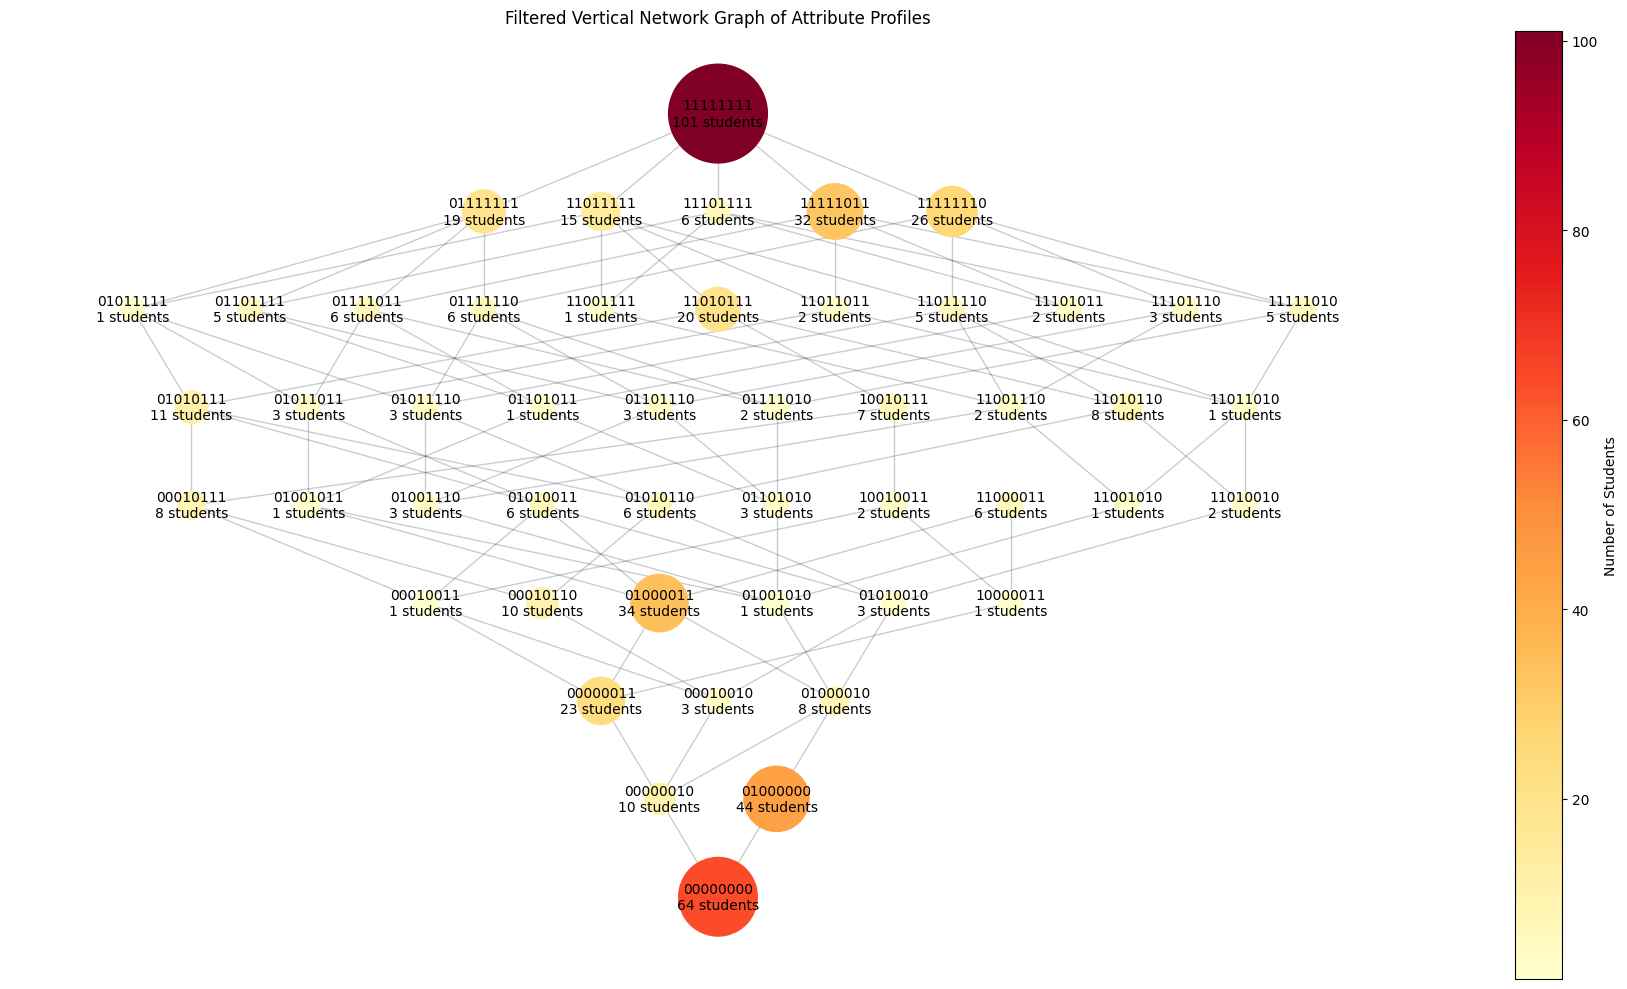

In [3]:
import itertools
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

# アトリビュート数を取得
num_attributes = attributes.shape[1]

# すべての可能な状態（アトリビュートプロファイル）を生成
states = list(itertools.product([0, 1], repeat=num_attributes))

# 各状態の学生数をカウント
state_counts = defaultdict(int)
for attr in attributes:
    state_counts[tuple(attr)] += 1

# 学生数がゼロの状態を除外
filtered_states = [state for state in states if state_counts[state] > 0]

# グラフ作成
G_filtered = nx.Graph()

# ノードを追加し、学生数を属性として設定
for state in filtered_states:
    G_filtered.add_node(state, count=state_counts[state])

# エッジを追加
for state in filtered_states:
    for i in range(num_attributes):
        next_state = list(state)
        if next_state[i] == 0:
            next_state[i] = 1
            next_state = tuple(next_state)
            if next_state in filtered_states:
                G_filtered.add_edge(state, next_state)

# カスタムレイアウト
def custom_layout(G, num_attributes):
    pos = {}
    levels = {}
    for state in G.nodes():
        level = sum(state)  # 状態の1の数でレベルを定義
        if level not in levels:
            levels[level] = []
        levels[level].append(state)
    
    # レベルごとにノードを配置
    for level, states_at_level in levels.items():
        num_nodes_at_level = len(states_at_level)
        for i, state in enumerate(sorted(states_at_level)):
            x = i - (num_nodes_at_level - 1) / 2
            y = level
            pos[state] = (x, y)
    return pos

# レイアウトを適用
pos_filtered = custom_layout(G_filtered, num_attributes)

# グラフ設定
plt.figure(figsize=(18, 10))
nx.draw_networkx_edges(G_filtered, pos_filtered, alpha=0.2)

# ノードのサイズと色を学生数に基づいて調整
node_sizes_filtered = [max(300, state_counts[node] * 50) for node in G_filtered.nodes()]
node_colors_filtered = [state_counts[node] for node in G_filtered.nodes()]
nodes_filtered = nx.draw_networkx_nodes(
    G_filtered, pos_filtered, node_size=node_sizes_filtered, node_color=node_colors_filtered, cmap=plt.cm.YlOrRd
)

# ラベルを追加
labels_filtered = {node: f"{''.join(map(str, node))}\n{state_counts[node]} students" for node in G_filtered.nodes()}
nx.draw_networkx_labels(G_filtered, pos_filtered, labels_filtered, font_size=10)

# カラーバーの追加
plt.colorbar(nodes_filtered, label='Number of Students')

# グラフの仕上げ
plt.title('Filtered Vertical Network Graph of Attribute Profiles')
plt.axis('off')
plt.tight_layout()
plt.show()


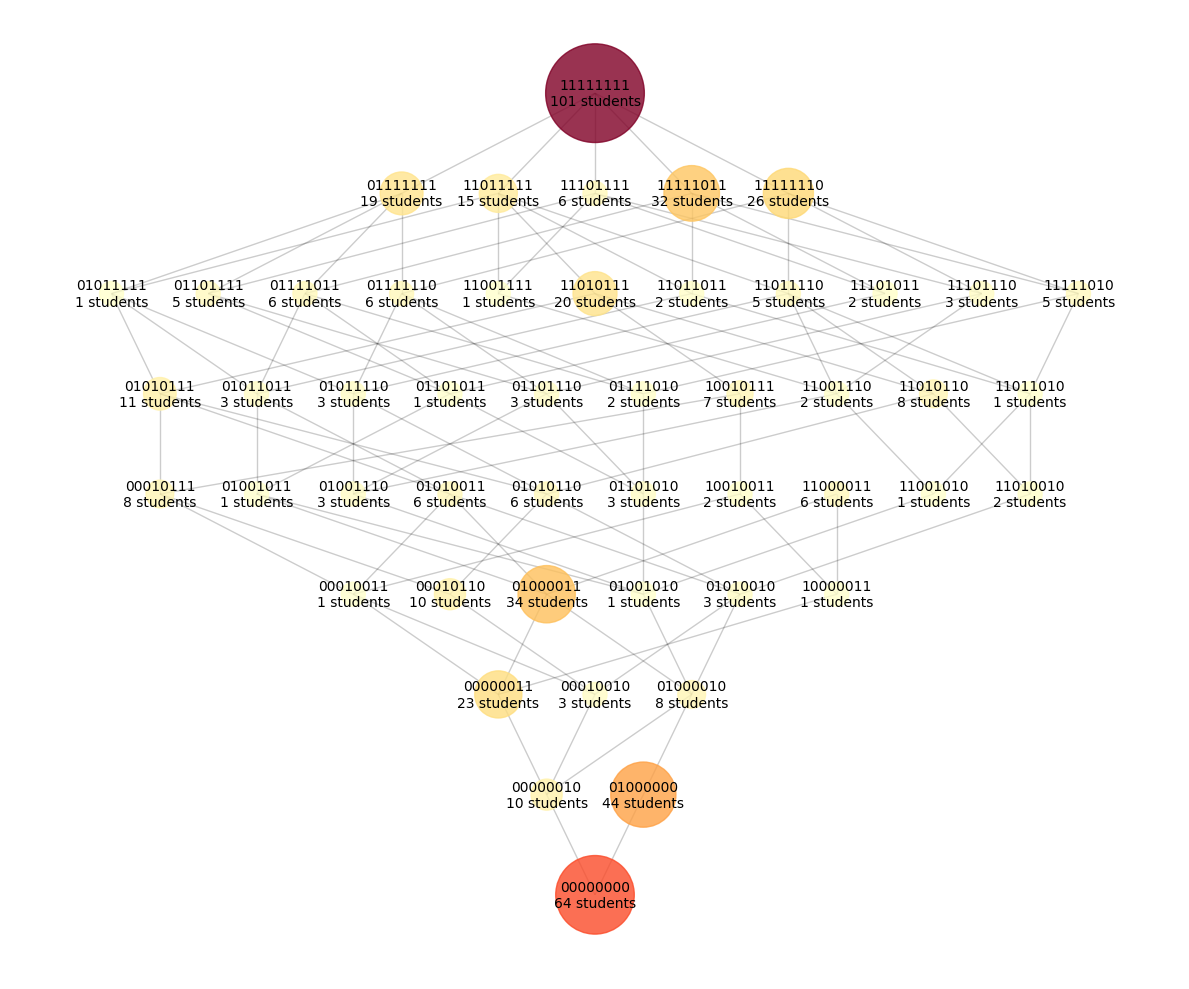

In [9]:
import itertools
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

# アトリビュート数を取得
num_attributes = attributes.shape[1]

# すべての可能な状態（アトリビュートプロファイル）を生成
states = list(itertools.product([0, 1], repeat=num_attributes))

# 各状態の学生数をカウント
state_counts = defaultdict(int)
for attr in attributes:
    state_counts[tuple(attr)] += 1

# 学生数がゼロの状態を除外
filtered_states = [state for state in states if state_counts[state] > 0]

# グラフ作成
G_filtered = nx.Graph()

# ノードを追加し、学生数を属性として設定
for state in filtered_states:
    G_filtered.add_node(state, count=state_counts[state])

# エッジを追加
for state in filtered_states:
    for i in range(num_attributes):
        next_state = list(state)
        if next_state[i] == 0:
            next_state[i] = 1
            next_state = tuple(next_state)
            if next_state in filtered_states:
                G_filtered.add_edge(state, next_state)

# カスタムレイアウト
def custom_layout(G, num_attributes):
    pos = {}
    levels = {}
    for state in G.nodes():
        level = sum(state)  # 状態の1の数でレベルを定義
        if level not in levels:
            levels[level] = []
        levels[level].append(state)
    
    # レベルごとにノードを配置
    for level, states_at_level in levels.items():
        num_nodes_at_level = len(states_at_level)
        for i, state in enumerate(sorted(states_at_level)):
            x = i - (num_nodes_at_level - 1) / 2
            y = level
            pos[state] = (x, y)
    return pos

# レイアウトを適用
pos_filtered = custom_layout(G_filtered, num_attributes)

# グラフ設定
plt.figure(figsize=(12, 10))
nx.draw_networkx_edges(G_filtered, pos_filtered, alpha=0.2)

# ノードのサイズと色を学生数に基づいて調整
node_sizes_filtered = [max(300, state_counts[node] * 50) for node in G_filtered.nodes()]
node_colors_filtered = [state_counts[node] for node in G_filtered.nodes()]
nodes_filtered = nx.draw_networkx_nodes(
    G_filtered, pos_filtered, node_size=node_sizes_filtered, node_color=node_colors_filtered, cmap=plt.cm.YlOrRd, alpha=0.8
)

# ラベルを追加
labels_filtered = {node: f"{''.join(map(str, node))}\n{state_counts[node]} students" for node in G_filtered.nodes()}
nx.draw_networkx_labels(G_filtered, pos_filtered, labels_filtered, font_size=10)

# カラーバーの追加
# plt.colorbar(nodes_filtered, label='Number of Students')

# グラフの仕上げ
# plt.title('Filtered Vertical Network Graph of Attribute Profiles')
plt.axis('off')
plt.tight_layout()
plt.show()